In [1]:
#Importing required lib / module

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import squarify 

In [63]:
#pip install squarify

# Creating DFs

In [2]:
# Loding files in separate dfs

aisles=pd.read_csv('../input/market-basket-analysis/aisles.csv')
departments=pd.read_csv('../input/market-basket-analysis/departments.csv')
orders=pd.read_csv('../input/market-basket-analysis/orders.csv')
products=pd.read_csv('../input/market-basket-analysis/products.csv')
sample_submission=pd.read_csv('../input/market-basket-analysis/sample_submission.csv')
order_products__prior=pd.read_csv('../input/market-basket-analysis/order_products__prior.csv')
order_products__train=pd.read_csv('../input/market-basket-analysis/order_products__train.csv')

# Cleaning DFs

In [65]:
# filling the na cells with -1

orders['days_since_prior_order']=orders['days_since_prior_order'].fillna(-1)

In [3]:
# checking if the dfs have any null values

print(orders.isna().sum())
print(aisles.isna().sum())
print(departments.isna().sum())
print(products.isna().sum())
print(sample_submission.isna().sum())
print(order_products__prior.isna().sum())
print(order_products__train.isna().sum())

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64
aisle_id    0
aisle       0
dtype: int64
department_id    0
department       0
dtype: int64
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64
order_id    0
products    0
dtype: int64
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64


# Merging DFs

In [67]:
#Merging  train order and prior orders first (to check)

Dataset_orders = pd.concat([order_products__prior, order_products__train]).sort_values(by=['order_id'])

In [68]:
#Concatenating with other DFs

Dataset_orders = pd.merge(left = Dataset_orders, right = products,
                             left_on='product_id', right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)
Dataset_orders = pd.merge(left = Dataset_orders, right = aisles,
                             left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
Dataset_orders = pd.merge(left = Dataset_orders, right = departments,
                             left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
Dataset_orders = pd.merge(left = Dataset_orders, right = orders,
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)

In [69]:
# Arranging columns of DF as per our need

Columns = ['user_id','order_id','add_to_cart_order','product_id','product_name','reordered','aisle_id','aisle','department_id',
 'department','eval_set','order_number','order_dow','order_hour_of_day',
 'days_since_prior_order']

Dataset_orders = Dataset_orders[Columns]

In [ ]:
Dataset_orders.shape


In [ ]:
Dataset_orders.head()

In [37]:
#import pickle

#Dataset_orders.to_csv("Final_dataset.csv",index=False)
#pickle.dump(Dataset_orders,open("F_D.pkl","wb"))

In [15]:
#Saving merged file for further use (not needed anymore)

#Dataset_orders.to_csv("Final_dataset.csv",index=False)
#Merged and cleaned dataset
#F_D=pd.read_csv('Final_dataset.csv')

# EDA

### 1. Number of orders and their frequency

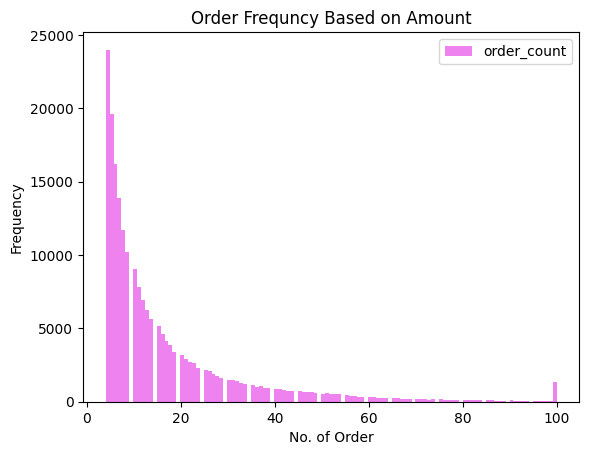

In [18]:
Count_f_orders = orders.groupby(['user_id'])['order_id'].agg(lambda group: len(group.unique()))\
                .reset_index(name='order_count')\
                .set_index('user_id')

# ED1

plt = Count_f_orders.plot.hist(bins = 115,color='violet')
plt.set_xlabel("No. of Order")
plt.set_title('Order Frequncy Based on Amount')
plt.legend()

### 2. Department Tree Map along with order rate and percentage reordered

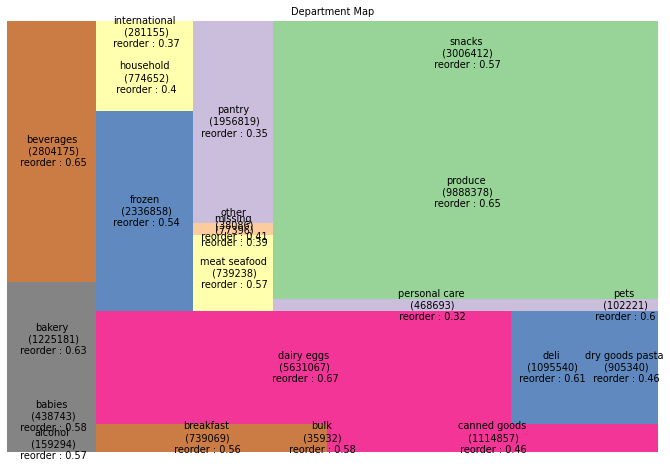

In [24]:
# Prepare Data
fg = Dataset_orders.groupby(['department']).size().reset_index(name='order_count')
DPR = Dataset_orders[Dataset_orders['reordered']==1].groupby(['department']).size().reset_index(name='reorder_rate')
fg['reorder_rate'] = DPR['reorder_rate']/fg['order_count']

labels = fg.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")" + "\n reorder : "+ str(round(x[2],2)) , axis=1)
sizes = fg['order_count'].values.tolist()
colors = [plt.cm.Accent_r(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(12,8), dpi= 70)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8, text_kwargs={'fontsize':10})

# Decorate
plt.title('Department Map', fontsize = 10)
plt.axis('off')
plt.show()


### 3. Most checkouts in a day

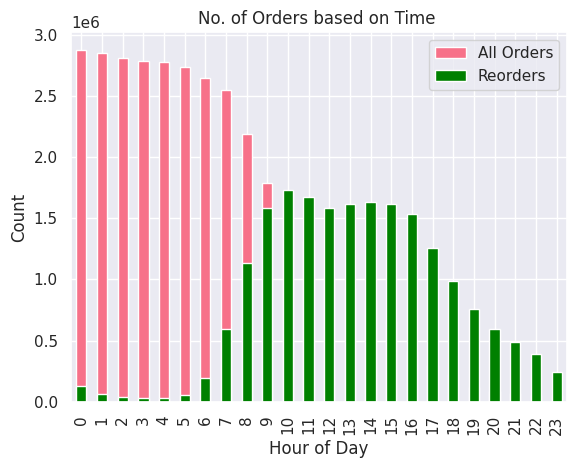

In [26]:
sns.set_theme(context='notebook', style='darkgrid', palette="husl")
ax = Dataset_orders['order_hour_of_day'].value_counts().plot.bar()
ax = Dataset_orders[Dataset_orders['reordered']==1].groupby(['order_hour_of_day']).size().plot.bar(color = 'g')
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Count")
ax.set_title('No. of Orders based on Time ')
ax.legend(["All Orders", "Reorders"])

# Recommendation

## Item - Item  Based Using Cosine Simillarity

In [27]:
# smaller training dataframe 

df = order_products__train[:600000].copy()
df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [28]:
# create sparse matrix of products and orders

Sparse_mat = df.pivot(index='product_id', columns='order_id', values='reordered')

# Fill about any null values with 0 as well as any non-null values with 1.

Sparse_mat[Sparse_mat.notnull()] = 1
Sparse_mat[Sparse_mat.isnull()] = 0

In [29]:
# Cosine Similiartiy Matrix

Sim_mat = cosine_similarity(Sparse_mat)

In [35]:
Sim_mat

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [36]:
# Saving Similarity Matrix in a pickle file

#import pickle
#product_sim_matrix.to_csv("Final_dataset.csv",index=False)
#pickle.dump(Sim_mat,open("similarity.pkl","wb"))

In [32]:
# Method to find similar products using the sim_mat 

# Arguments provided - Product ID, Similarity Matrix and the number of Similar Products

def Product_Recommendation(prod_id, Representation, n):
    
    idx = np.where(Sparse_mat.index == prod_id)[0][0]
    sim_lst = []
    Score = []
    Representation = Representation[idx]
    
    for k in range(len(Representation)):
        if Representation[k] > 0.05 and Representation[k] < 0.99:
            sim_lst.append(k)
            Score.append(Representation[k])
            
    order_match_list = Sparse_mat[Sparse_mat.reset_index().index.isin(sim_lst)].index.values.tolist()
      
    df = products[products['product_id'].isin(order_match_list)].copy()
    df['sim_score'] = Score
    df = df.sort_values(by=['sim_score'], ascending=False)
    df = df[:n]
    
    return df

In [33]:
# Find the prior rows

#Dataset_orders[(Dataset_orders["eval_set"]=="prior")]

# Getting Recommendations Based on the provided Product

In [55]:
# Coconut Butter

Product_Recommendation(45918, Sim_mat, 10)

,product_id,product_name,aisle_id,department_id,sim_score
3476,3477,"Fruit & Veggie 1,2,3",121,14,0.250000
34655,34656,Queso Blanco,78,19,0.250000
22608,22609,Whole Grain Millet,63,9,0.176777
8294,8295,Ultra Strength Ointment,133,11,0.176777
40789,40790,Organic Coconut Bliss Cherry Amaretto Frozen D...,37,1,0.176777
5004,5005,Coconut Cacao Drink,31,7,0.176777
41293,41294,Organic Superfood Coconut Flour Gluten-Free,17,13,0.144338
8881,8882,Organic White Potato,83,4,0.144338
13304,13305,100% Whey Protein Vanilla Flavor,65,11,0.144338
3821,3822,Green Magic Chia Squeeze,117,19,0.117851


In [38]:
# Carrot

Product_Recommendation(17794, Sim_mat, 10)

,product_id,product_name,aisle_id,department_id,sim_score
44358,44359,Organic Small Bunch Celery,83,4,0.096679
24963,24964,Organic Garlic,83,4,0.093004
22934,22935,Organic Yellow Onion,83,4,0.091423
45006,45007,Organic Zucchini,83,4,0.091348
21902,21903,Organic Baby Spinach,123,4,0.087541
34125,34126,Organic Italian Parsley Bunch,16,4,0.087081
4604,4605,Yellow Onions,83,4,0.086247
47625,47626,Large Lemon,24,4,0.083061
28984,28985,Michigan Organic Kale,83,4,0.081422
34357,34358,Garlic,83,4,0.081064


In [56]:
# organic turkey burgers

Product_Recommendation(23, Sim_mat, 10)

,product_id,product_name,aisle_id,department_id,sim_score
26987,26988,Chop House T Bone Steak Flavor Dog Food,40,8,0.169031
12647,12648,Sugar Free Chewy Caramel,45,19,0.169031
32069,32070,Iced Matcha Tea With A Hint of Honey,94,7,0.169031
22183,22184,Regenerist Micro-Exfoliating Wet Facial Cleans...,73,11,0.169031
16306,16307,Crystal Deodorant Stone,80,11,0.169031
49370,49371,Pouf Bath Sponge,132,11,0.169031
4608,4609,Sweet Baby Lettuce,123,4,0.169031
3435,3436,Egg Substitute,86,16,0.169031
7223,7224,Prime Cuts Homestyle With Beef In Gravy Dog Food,40,8,0.119523
31930,31931,Pure Fire Tonic Apple Cider Vinegar Drink,77,7,0.119523


In [57]:
# chicken & Rice Traditional Ground Dinner Dog Food

Product_Recommendation(12623, Sim_mat, 10)

,product_id,product_name,aisle_id,department_id,sim_score
12647,12648,Sugar Free Chewy Caramel,45,19,0.707107
22183,22184,Regenerist Micro-Exfoliating Wet Facial Cleans...,73,11,0.707107
26987,26988,Chop House T Bone Steak Flavor Dog Food,40,8,0.707107
3435,3436,Egg Substitute,86,16,0.707107
22545,22546,Choice Cuts In Gravy Country Stew Wet Dog Food,40,8,0.500000
7223,7224,Prime Cuts Homestyle With Beef In Gravy Dog Food,40,8,0.500000
7705,7706,"Lamb & Rice Prime Cuts in Gravy Tender, Meaty ...",40,8,0.500000
45441,45442,Air Effects Gain Original Scent,101,17,0.500000
48272,48273,Choice Cuts In Gravy W/Beef (PS #1211231) Wet ...,40,8,0.408248
32250,32251,Sugar Free Hard Candies,45,19,0.408248


In [58]:
# Blackberry Cucumber Sparkling Water

Product_Recommendation(39947, Sim_mat, 10)

,product_id,product_name,aisle_id,department_id,sim_score
12575,12576,Kiwi Sandia Sparkling Water,115,7,0.268926
45746,45747,Curate Melon Pomelo Sparking Water,115,7,0.203554
30352,30353,Curate Cherry Lime Sparkling Water,115,7,0.170772
27274,27275,Pineapple Strawberry Sparkling Water,115,7,0.126543
31963,31964,Passionfruit Sparkling Water,115,7,0.123688
12301,12302,"Sparkling Water, Natural Mango Essenced",115,7,0.100385
7692,7693,Cran-Raspberry Flavored Sparkling Water,115,7,0.086998
41681,41682,Curate Pomme Baya-Apple Berry Sparkling Water,115,7,0.084337
43276,43277,Pitted Organic Kalamata Olives To Go!,110,13,0.078027
1830,1831,Peach-Pear Sparkling Water,115,7,0.074256


In [59]:
# Lemon Humus

Product_Recommendation(13646, Sim_mat, 10)

,product_id,product_name,aisle_id,department_id,sim_score
37951,37952,Soup Lentil,69,15,0.071474
48102,48103,Mini Banana Chocolate Chip Bars Snack Cakes,112,3,0.070186
1574,1575,"Melba Toast, Classic",78,19,0.061898
1671,1672,English Cucumbers,32,4,0.061898
48562,48563,Organic Dark Chocolate With Toasted Almond Pie...,45,19,0.061898
47175,47176,Comforting Geranium Aromatherapy Mineral Bath,25,11,0.061898
45870,45871,Mixed Beans,59,15,0.061898
43848,43849,Organic Very Dark Chocolate Bar,45,19,0.061898
40009,40010,Rolled Fillets Of Anchovies,95,15,0.061898
37994,37995,Calabrese Spicy Salame with Sangiovese Wine,96,20,0.061898


In [60]:
# Natural Sweetener

Product_Recommendation(30035, Sim_mat, 10)

,product_id,product_name,aisle_id,department_id,sim_score
19273,19274,Organic Brown Sugar,17,13,0.353553
4032,4033,Nightly Calm Herbal Tea K-Cup Pods,94,7,0.353553
12687,12688,Children's Grape Flavor Nighttime Cough Syrup,11,11,0.250000
38879,38880,Pure Green Tea K-Cups,94,7,0.250000
22329,22330,Garlic & Herb Shirataki Pasta,131,9,0.250000
19949,19950,Cauliflower Pizza Crusts,128,3,0.250000
27143,27144,Organic Chocolate Rooibos Caffeine Free Tea,94,7,0.204124
4915,4916,Disney Frozen Berry Cherry Raspberry Ice Pops,37,1,0.176777
41997,41998,Lite Honey Mustard Vinaigrette Dressing Lite,89,13,0.176777
27259,27260,Cafe Latte Vanilla,98,7,0.176777
